## Notebook for data processing and analysis

**Original Author:** Luka Corsovic and Ema Vargova.<br/>
**Last Modified:** By Luka Corsovic on the 07.07.2021.

### Acessing libraries

In [12]:
# Import the findspark module 
import findspark

# Initialize via the full spark path
findspark.init("/usr/local/spark/")

# Import the SparkSession module
from pyspark.sql import SparkSession

# Import the collections module
import collections

from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from dateutil import parser
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType, DecimalType, FloatType
from datetime import date, timezone, datetime, timedelta

# Models
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import  StringIndexer
from pyspark.ml import Pipeline 

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Plots
import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Openning Spark session

In [4]:
# Gets an existing :class:`SparkSession` or, if there is no existing one, creates a
# new one based on the options set in this builder.
spark = SparkSession.builder \
   .master("local[8]") \
   .appName("models") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

# Main entry point for Spark functionality. A SparkContext represents the
# connection to a Spark cluster, and can be used to create :class:`RDD` and
# broadcast variables on that cluster.
sc = spark.sparkContext

### Data processing and combining the datasets

In [5]:
#list of cities
cities = ["London","Dublin","Belfast","Manchester","Liverpool","Miami","LA","Dallas"] 
location_cat = [0,1,2,3,4,5,6,7]
for i in range(len(cities)): #iterate over the cities
    #path for the tweets for the specific city
    path_tweets = "twitter/results_tweets/tweets_city_1_"+cities[i]+"/*.json" 
    tweets = spark.read.json(path_tweets) #read the tweets
    #path for the weather data for the city
    path_weather = "weather/weather_data/210701_weather_"+cities[i]+"/*.csv" 
    weather = spark.read.csv(path_weather, header=True, inferSchema =True) #read the weather data
    
    tweets = tweets.filter(tweets.location.contains(cities[i])) #filter only for Belfast
    #filtering the location to only say the name of the city
    tweets = tweets.withColumn("location" , when(tweets.location != cities[i], 
                                                 cities[i]).otherwise(cities[i])) 
    date_parser = udf(parser.parse, TimestampType()) #creating the date parsing function
    tweets = tweets.withColumn("created_at" , date_parser("created_at")) #parsing the date of the tweets
    #rounding up the hours of the tweets
    tweets = tweets.withColumn("created_at_hourly", date_trunc("hour", col("created_at"))) 

    #creating the unix time
    tweets = tweets.withColumn("unix_created_at",unix_timestamp('created_at_hourly')) 
    tweets = tweets.withColumn("location_cat",when(tweets.location != location_cat[i], 
                                                   location_cat[i]).otherwise(location_cat[i]))
    tweets = tweets.withColumn("subjectivity",tweets.subjectivity.cast("double"))
    tweets = tweets.withColumn("polarity",tweets.polarity.cast("double"))
    if i == 0:
        #joining first tweet and weather dataset
        df = tweets.join(weather, tweets.unix_created_at == weather.dt, 'left').select('*') 
    else:
        df_append = tweets.join(weather, tweets.unix_created_at == weather.dt, 'left').select('*') 
        df = df.union(df_append) #appending the reamining datasets to it

In [6]:
df.dtypes #printing the data types

[('created_at', 'timestamp'),
 ('location', 'string'),
 ('polarity', 'double'),
 ('screen_name', 'string'),
 ('subjectivity', 'double'),
 ('word', 'string'),
 ('created_at_hourly', 'timestamp'),
 ('unix_created_at', 'bigint'),
 ('location_cat', 'int'),
 ('lat', 'double'),
 ('lon', 'double'),
 ('timezone', 'string'),
 ('timezone_offset', 'int'),
 ('clouds', 'int'),
 ('dew_point', 'double'),
 ('dt', 'int'),
 ('feels_like', 'double'),
 ('humidity', 'int'),
 ('pressure', 'int'),
 ('temp', 'double'),
 ('visibility', 'int'),
 ('wind_deg', 'int'),
 ('wind_speed', 'double')]

In [6]:
file_path = 'tweets_with_weather'
df.write.mode('overwrite').save(file_path, format="csv", header='true')

In [7]:
df_org=df.select('polarity','subjectivity','clouds','dew_point','feels_like','humidity',
                 'pressure','temp','visibility','wind_deg','wind_speed')
df_org.dtypes

[('polarity', 'double'),
 ('subjectivity', 'double'),
 ('clouds', 'int'),
 ('dew_point', 'double'),
 ('feels_like', 'double'),
 ('humidity', 'int'),
 ('pressure', 'int'),
 ('temp', 'double'),
 ('visibility', 'int'),
 ('wind_deg', 'int'),
 ('wind_speed', 'double')]

In [8]:
pandasDF = df_org.toPandas() #converting the dataframe to pandas for the visulisations

array([[<AxesSubplot:title={'center':'polarity'}>]], dtype=object)

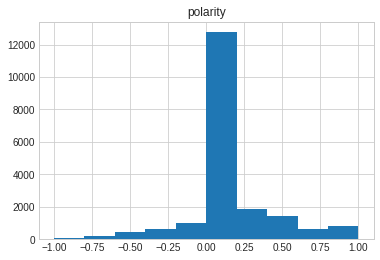

In [11]:
pandasDF.hist(column='polarity') #plotting the polarity histogram

array([[<AxesSubplot:title={'center':'subjectivity'}>]], dtype=object)

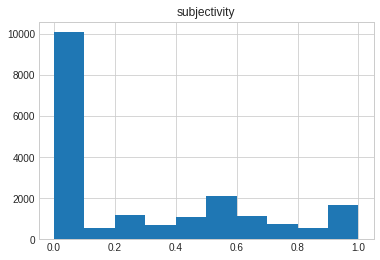

In [12]:
pandasDF.hist(column='subjectivity') #plotting the subjectivity histogram

### Models

#### Linear Model - polarity

In [15]:
# Use a lambda function to create an RDD with the label and a dense vector of features
input_data = df_org.rdd.map(lambda x: (x[0], DenseVector(x[2:])))

# Creates a :class:`DataFrame` from an :class:`RDD`, a list or a :class:`pandas.DataFrame`.
df = spark.createDataFrame(input_data, ["label", "features"])

# Prints the first row to the console.
df.take(1)

[Row(label=0.0, features=DenseVector([20.0, 8.66, 14.95, 59.0, 1016.0, 16.7, 10000.0, 120.0, 2.06]))]

In [16]:
# Standardizes features by removing the mean and scaling to unit variance using column summary
# statistics on the samples in the training set.
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fits a model to the input dataset with optional parameters.
scaler = standardScaler.fit(df)

# Transforms the input dataset with optional parameters.
scaled_df = scaler.transform(df)

# Prints the first row to the console.
scaled_df.take(1)

[Row(label=0.0, features=DenseVector([20.0, 8.66, 14.95, 59.0, 1016.0, 16.7, 10000.0, 120.0, 2.06]), features_scaled=DenseVector([0.8453, 1.8132, 2.8201, 4.436, 1065.9288, 4.6401, 2.9975, 0.9593, 1.8258]))]

In [17]:
# Randomly splits this :class:`DataFrame` with the provided weights.
train_data, test_data = scaled_df.randomSplit([.8,.2],seed=1234)

In [18]:
# Linear regression.
# The learning objective is to minimize the specified loss function, with regularization.
lr = LinearRegression(labelCol="label", maxIter=10000, regParam=0.01, elasticNetParam=0.4)

# Fits a model to the input dataset with optional parameters.
linearModel = lr.fit(train_data)

In [19]:
# Transforms the input dataset with optional parameters.
predicted = linearModel.transform(test_data)

# Projects a set of expressions and returns a new :class:`DataFrame`.
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])

# Projects a set of expressions and returns a new :class:`DataFrame`.
labels = predicted.select("label").rdd.map(lambda x: x[0])

# Zips this RDD with another one, returning key-value pairs with the
# first element in each RDD second element in each RDD, etc. Assumes
# that the two RDDs have the same number of partitions and the same
# number of elements in each partition (e.g. one was made through
# a map on the other).  
predictionAndLabel = predictions.zip(labels).collect()

# Built-in mutable sequence.
# Print out first 5 instances of `predictionAndLabel` 
predictionAndLabel[:5]

[(0.10406678082076759, -1.0),
 (0.10497393182257042, -1.0),
 (0.1012270678749232, -1.0),
 (0.1021107364731293, -1.0),
 (0.1021107364731293, -1.0)]

In [20]:
# Model coefficients.
linearModel.coefficients

DenseVector([0.0, 0.0, -0.0014, 0.0, 0.0046, 0.0, -0.0, 0.0, 0.0])

In [21]:
# Model intercept.
linearModel.intercept

-4.537920137401679

In [22]:
# Returns the root mean squared error, which is defined as the
# square root of the mean squared error.
linearModel.summary.rootMeanSquaredError

0.29070160389675037

In [23]:
# Returns R^2, the coefficient of determination.
linearModel.summary.r2

0.0038382574467263897

<AxesSubplot:xlabel='feels_like', ylabel='polarity'>

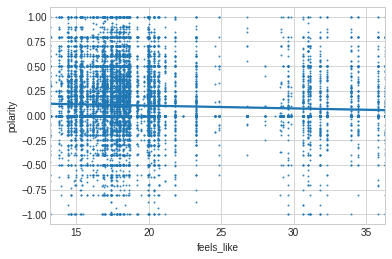

In [22]:
sb.regplot(x = 'feels_like', y = 'polarity', data=pandasDF, scatter_kws={'s':1}) #plotting the regression with the subjective temperature on the x axis and polarity on the y axis

<AxesSubplot:xlabel='pressure', ylabel='polarity'>

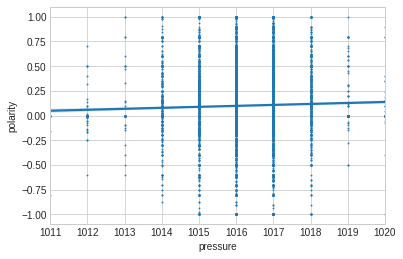

In [23]:
sb.regplot(x = 'pressure', y = 'polarity', data=pandasDF, scatter_kws={'s':1}) #plotting the regression model with the air pressure on the x axis and the polarity on the y value

#### Linear Model - subjectivity

In [16]:
# Import the DenseVector Module
from pyspark.ml.linalg import DenseVector

# Use a lambda function to create an RDD with the label and a dense vector of features
input_data = df_org.rdd.map(lambda x: (x[1], DenseVector(x[2:])))

# Creates a :class:`DataFrame` from an :class:`RDD`, a list or a :class:`pandas.DataFrame`.
df = spark.createDataFrame(input_data, ["label", "features"])

# Prints the first row to the console.
df.take(1)

[Row(label=0.0, features=DenseVector([20.0, 8.66, 14.95, 59.0, 1016.0, 16.7, 10000.0, 120.0, 2.06, 0.0]))]

In [17]:
# Import the StandardScaler Module
from pyspark.ml.feature import StandardScaler

# Standardizes features by removing the mean and scaling to unit variance using column summary
# statistics on the samples in the training set.
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fits a model to the input dataset with optional parameters.
scaler = standardScaler.fit(df)

# Transforms the input dataset with optional parameters.
scaled_df = scaler.transform(df)

# Prints the first row to the console.
scaled_df.take(1)

[Row(label=0.0, features=DenseVector([20.0, 8.66, 14.95, 59.0, 1016.0, 16.7, 10000.0, 120.0, 2.06, 0.0]), features_scaled=DenseVector([0.8453, 1.8132, 2.8201, 4.436, 1065.9288, 4.6401, 2.9975, 0.9593, 1.8258, 0.0]))]

In [18]:
# Randomly splits this :class:`DataFrame` with the provided weights.
train_data, test_data = scaled_df.randomSplit([.8,.2],seed=1234)

In [19]:
# Import the LinearRegression Module
from pyspark.ml.regression import LinearRegression

# Linear regression.
# The learning objective is to minimize the specified loss function, with regularization.
lr = LinearRegression(labelCol="label", maxIter=10000, regParam=0.01, elasticNetParam=0.4)

# Fits a model to the input dataset with optional parameters.
linearModel = lr.fit(train_data)

In [20]:
# Transforms the input dataset with optional parameters.
predicted = linearModel.transform(test_data)

# Projects a set of expressions and returns a new :class:`DataFrame`.
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])

# Projects a set of expressions and returns a new :class:`DataFrame`.
labels = predicted.select("label").rdd.map(lambda x: x[0])

# Zips this RDD with another one, returning key-value pairs with the
# first element in each RDD second element in each RDD, etc. Assumes
# that the two RDDs have the same number of partitions and the same
# number of elements in each partition (e.g. one was made through
# a map on the other).  
predictionAndLabel = predictions.zip(labels).collect()

# Built-in mutable sequence.
# Print out first 5 instances of `predictionAndLabel` 
predictionAndLabel[:5]

[(0.2955105931504871, 0.0),
 (0.2955105931504871, 0.0),
 (0.2955105931504871, 0.0),
 (0.2955105931504871, 0.0),
 (0.2955105931504871, 0.0)]

In [21]:
# Model coefficients.
linearModel.coefficients

DenseVector([0.0, 0.0, -0.0006, 0.0, 0.0018, -0.0025, -0.0, 0.0, 0.0, 0.0])

In [23]:
# Model intercept.
linearModel.intercept

-1.5028698385749282

In [24]:
# Returns the root mean squared error, which is defined as the
# square root of the mean squared error.
linearModel.summary.rootMeanSquaredError

0.3382669439079013

In [25]:
# Returns R^2, the coefficient of determination.
linearModel.summary.r2

0.003367172312823574

<AxesSubplot:xlabel='feels_like', ylabel='subjectivity'>

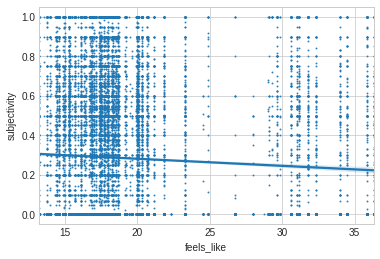

In [35]:
sb.regplot(x = 'feels_like', y = 'subjectivity', data=pandasDF, scatter_kws={'s':1}) #visualising the regression model with the subjective temperature on the x axis and the subjectivity on the y axis

<AxesSubplot:xlabel='pressure', ylabel='subjectivity'>

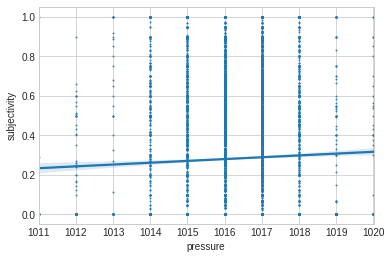

In [37]:
sb.regplot(x = 'pressure', y = 'subjectivity', data=pandasDF, scatter_kws={'s':1}) #plotting the regression model with the air pressure on the x axis and subjectivity on the y axis

<AxesSubplot:xlabel='temp', ylabel='subjectivity'>

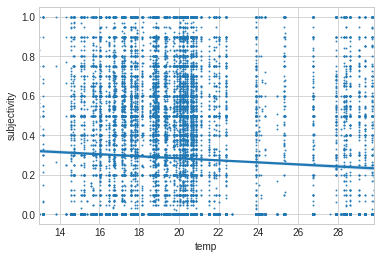

In [39]:
sb.regplot(x = 'temp', y = 'subjectivity', data=pandasDF, scatter_kws={'s':1}) #plotting the regression model with temperature on the x axis and subjectivity on the y axis

### Logistic regression

In [63]:
df_log = df_org.select('subjectivity','clouds','feels_like','humidity','pressure','temp','visibility','wind_speed') #choosing the necessary variables

df_log = df_log.withColumn("subjectivity", df_log.subjectivity.cast(FloatType()).alias("subjectivity")) #casting the subjectivity to a float type
df_log = df_log.withColumn("subjectivity" , when((df_log.subjectivity >= 0.6),1 ).otherwise(0)) #converting the subjectivity to binary

In [64]:
pandasDF_log = df_log.toPandas() #converting the dataframe to pandas to visualise it

array([[<AxesSubplot:title={'center':'subjectivity'}>]], dtype=object)

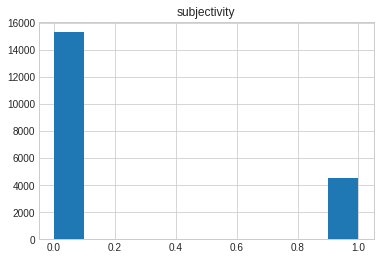

In [65]:
pandasDF_log.hist(column='subjectivity') #visualising the subjectivity

In [66]:
df_log = df_log.withColumn("subjectivity", df_log.subjectivity.cast(StringType()).alias("subjectivity")) #converting the subjectivity back to string type

indexers = [StringIndexer(inputCol="subjectivity", outputCol = "label"),  #creating the indexers for the different weather features
           StringIndexer(inputCol="clouds", outputCol = "clouds_index"), 
           StringIndexer(inputCol="feels_like", outputCol = "feels_like_index"),
           StringIndexer(inputCol= "humidity" , outputCol = "humidity_index"),
           StringIndexer(inputCol = "pressure" , outputCol = "pressure_index"), 
           StringIndexer(inputCol = "temp" ,  outputCol = "temp_index") , 
           StringIndexer(inputCol = "wind_speed" , outputCol = "wind_speed_index"),
           StringIndexer(inputCol = "visibility" , outputCol= "visibility_index")]

In [67]:
pipeline = Pipeline(stages=indexers) #creating the pipeline with the appropriate indexers
index_df_log = pipeline.fit(df_log).transform(df_log) #running the dataframe through the pipeline with the indexers

In [68]:
vectorAssembler = VectorAssembler(inputCols = [ "clouds_index", "feels_like_index", "humidity_index", 
                                               "pressure_index" , "visibility_index" , "temp_index" , 
                                               "wind_speed_index" , "visibility_index"],
                                  outputCol = "features") #creating the column features with the other weather features using the vector asembler
vind_df_log = vectorAssembler.transform(index_df_log) #transforming the dataset using the vector asembler

In [69]:
vind_df_log = vind_df_log.select( "clouds_index", "feels_like_index" , "humidity_index" , "pressure_index" , "visibility_index" , "temp_index" , "wind_speed_index" , "visibility_index", "label") #selecting the indexed variables from the dataset for the analysis
vectorAssembler = VectorAssembler(inputCols = [ "clouds_index", "feels_like_index" , "humidity_index" , "pressure_index" , "visibility_index" , "temp_index" , "wind_speed_index" , "visibility_index"],outputCol = "features") #creating the features vector again
vind_df_log = vectorAssembler.transform(vind_df_log) #running the dataset through the vector assembler again

In [70]:
splits = vind_df_log.randomSplit([0.7,0.3], 42) # creating the split
train_df = splits[0] #creating a training dataset that will contain 70% of the data
test_df = splits[1] #creating a test dataset that will contain 30% of the data

In [71]:
lr = LogisticRegression(maxIter=1, regParam=0.3, elasticNetParam=0.8) #creating the logistic regression model
lrModel = lr.fit(train_df) #fitting the model to the training data set

In [38]:
trainingSummary = lrModel.summary #extracting the summary from the model
accuracy = trainingSummary.accuracy #extracting the accuracy from the summary
falsePositiveRate = trainingSummary.weightedFalsePositiveRate #false positive rate in the model
truePositiveRate = trainingSummary.weightedTruePositiveRate #true positive rate in the model
fMeasure = trainingSummary.weightedFMeasure() #extracting the f-measure
precision = trainingSummary.weightedPrecision #extracing the precision metric
recall = trainingSummary.weightedRecall #extracting the recall metric
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall)) #printing out the extracted metrics in order to evaluate the model

Accuracy: 0.7749785897801884
FPR: 0.7749785897801884
TPR: 0.7749785897801884
F-measure: 0.6767313341983086
Precision: 0.6005918146176896
Recall: 0.7749785897801884


### Logistic regression - polarity

In [83]:
df_log = df_org.select('polarity','clouds','feels_like','humidity','pressure','temp','visibility','wind_speed') #choosing the necessary variables
df_log = df_log.withColumn("polarity", df_log.polarity.cast(FloatType()).alias("polarity")) #casting the polarity to a float type
df_log = df_log.withColumn("polarity" , when((df_log.polarity >= 0.2),1 ).otherwise(0)) #converting the polarity to binary

In [84]:
pandasDF_log = df_log.toPandas() #converting the dataframe to pandas to visualise it

array([[<AxesSubplot:title={'center':'polarity'}>]], dtype=object)

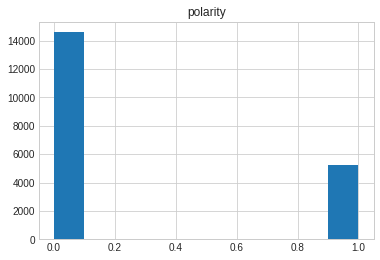

In [85]:
pandasDF_log.hist(column='polarity') #visualising the polarity

In [86]:
df_log = df_log.withColumn("polarity", df_log.polarity.cast(StringType()).alias("polarity")) #converting the polarity back to string type

indexers = [StringIndexer(inputCol="polarity", outputCol = "label"),  #creating the indexers for the different weather features
           StringIndexer(inputCol="clouds", outputCol = "clouds_index"), 
           StringIndexer(inputCol="feels_like", outputCol = "feels_like_index"),
           StringIndexer(inputCol= "humidity" , outputCol = "humidity_index"),
           StringIndexer(inputCol = "pressure" , outputCol = "pressure_index"), 
           StringIndexer(inputCol = "temp" ,  outputCol = "temp_index") , 
           StringIndexer(inputCol = "wind_speed" , outputCol = "wind_speed_index"),
           StringIndexer(inputCol = "visibility" , outputCol= "visibility_index")]

In [87]:
pipeline = Pipeline(stages=indexers) #creating the pipeline with the appropriate indexers
index_df_log = pipeline.fit(df_log).transform(df_log) #running the dataframe through the pipeline with the indexers

In [88]:
vectorAssembler = VectorAssembler(inputCols = [ "clouds_index", "feels_like_index", "humidity_index", 
                                               "pressure_index" , "visibility_index" , "temp_index" , 
                                               "wind_speed_index" , "visibility_index"],
                                  outputCol = "features") #creating the column features with the other weather features using the vector asembler
vind_df_log = vectorAssembler.transform(index_df_log) #transforming the dataset using the vector asembler

In [89]:
vind_df_log = vind_df_log.select( "clouds_index", "feels_like_index" , "humidity_index" , "pressure_index" , "visibility_index" , "temp_index" , "wind_speed_index" , "visibility_index", "label") #selecting the indexed variables from the dataset for the analysis
vectorAssembler = VectorAssembler(inputCols = [ "clouds_index", "feels_like_index" , "humidity_index" , "pressure_index" , "visibility_index" , "temp_index" , "wind_speed_index" , "visibility_index"],outputCol = "features") #creating the features vector again
vind_df_log = vectorAssembler.transform(vind_df_log) #running the dataset through the vector assembler again

In [90]:
splits = vind_df_log.randomSplit([0.7,0.3], 42)  # creating the split
train_df = splits[0] #creating a training dataset that will contain 70% of the data
test_df = splits[1] #creating a test dataset that will contain 30% of the data

In [91]:
lr = LogisticRegression(maxIter=1, regParam=0.3, elasticNetParam=0.8) #creating the logistic regression model
lrModel = lr.fit(train_df) #fitting the model to the training data set

In [92]:
trainingSummary = lrModel.summary #fitting the model to the training data set
accuracy = trainingSummary.accuracy  #extracting the accuracy from the summary
falsePositiveRate = trainingSummary.weightedFalsePositiveRate #false positive rate in the model
truePositiveRate = trainingSummary.weightedTruePositiveRate #true positive rate in the model
fMeasure = trainingSummary.weightedFMeasure() #extracting the f-measure
precision = trainingSummary.weightedPrecision #extracing the precision metric
recall = trainingSummary.weightedRecall #extracting the recall metric
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall)) #printing out the extracted metrics in order to evaluate the model

Accuracy: 0.7380102769055096
FPR: 0.7380102769055096
TPR: 0.7380102769055096
F-measure: 0.6267617355956041
Precision: 0.5446591688181469
Recall: 0.7380102769055096


### Naive Bayes - subjectivity

In [13]:
df_nb=df_org.select('subjectivity','clouds','feels_like','humidity','pressure','temp','visibility','wind_speed') #selecting the appropriate vairables for subjectivity

In [14]:
indexers = [StringIndexer(inputCol="subjectivity", outputCol = "label"), #creating the appropriate indexers 
           StringIndexer(inputCol="clouds", outputCol = "clouds_index"), 
           StringIndexer(inputCol="feels_like", outputCol = "feels_like_index"),
           StringIndexer(inputCol= "humidity" , outputCol = "humidity_index"),
           StringIndexer(inputCol = "pressure" , outputCol = "pressure_index"), 
           StringIndexer(inputCol = "temp" ,  outputCol = "temp_index") , 
           StringIndexer(inputCol = "wind_speed" , outputCol = "wind_speed_index"),
           StringIndexer(inputCol = "visibility" , outputCol= "visibility_index")]

In [15]:
pipeline = Pipeline(stages=indexers) #creating the pipeline with the indexers
index_df_nb = pipeline.fit(df_nb).transform(df_nb) #running the dataset through the pipeline

In [17]:
vectorAssembler = VectorAssembler(inputCols = ["clouds_index", "feels_like_index" , "humidity_index" , "pressure_index" , "visibility_index" , "temp_index" , "wind_speed_index" , "visibility_index"],outputCol = "features") #initializing the vector assembler in order to create the features column
vindexed_df_nb = vectorAssembler.transform(index_df_nb) #running the dataset through the vector assembler

In [18]:
splits = vindexed_df_nb.randomSplit([0.7,0.3], 42)    # creating the splits
train_df = splits[0] #creating the training data set
test_df = splits[1] #creating the test dataset

In [19]:
nb = NaiveBayes(modelType="multinomial") #creating the naive bayes model
nbmodel = nb.fit(train_df) #fitting the model on the training dataset

In [20]:
predictions_df = nbmodel.transform(test_df) #saving the predictions of the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") #creating the evaluator
nbaccuracy = evaluator.evaluate(predictions_df) #saving the accuracy metric based on the predictions
print("Test set accuracy = " + str(nbaccuracy)) #printing out the accuracy metric

Test set accuracy = 0.3234232686028527


### Naive Bayes - polarity

In [21]:
df_nb=df_org.select('polarity','clouds','feels_like','humidity','pressure','temp','visibility','wind_speed') #selecting the appropriate vairables for polarity

In [22]:
indexers = [StringIndexer(inputCol="polarity", outputCol = "label"), #creating the appropriate indexers 
           StringIndexer(inputCol="clouds", outputCol = "clouds_index"), 
           StringIndexer(inputCol="feels_like", outputCol = "feels_like_index"),
           StringIndexer(inputCol= "humidity" , outputCol = "humidity_index"),
           StringIndexer(inputCol = "pressure" , outputCol = "pressure_index"), 
           StringIndexer(inputCol = "temp" ,  outputCol = "temp_index") , 
           StringIndexer(inputCol = "wind_speed" , outputCol = "wind_speed_index"),
           StringIndexer(inputCol = "visibility" , outputCol= "visibility_index")]

In [23]:
pipeline = Pipeline(stages=indexers) #creating the pipeline with the indexers
index_df_nb = pipeline.fit(df_nb).transform(df_nb) #running the dataset through the pipeline

In [24]:
vectorAssembler = VectorAssembler(inputCols = ["clouds_index", "feels_like_index" , "humidity_index" , "pressure_index" , "visibility_index" , "temp_index" , "wind_speed_index" , "visibility_index"],outputCol = "features") #initializing the vector assembler in order to create the features column
vindexed_df_nb = vectorAssembler.transform(index_df_nb) #running the dataset through the vector assembler

In [25]:
splits = vindexed_df_nb.randomSplit([0.7,0.3], 42)    # creating the splits
train_df = splits[0] #creating the training data set
test_df = splits[1] #creating the test dataset

In [26]:
nb = NaiveBayes(modelType="multinomial") #creating the naive bayes model
nbmodel = nb.fit(train_df) #fitting the model on the training dataset

In [27]:
predictions_df = nbmodel.transform(test_df) #saving the predictions of the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") #creating the evaluator
nbaccuracy = evaluator.evaluate(predictions_df) #saving the accuracy metric based on the predictions
print("Test set accuracy = " + str(nbaccuracy)) #printing out the accuracy metric

Test set accuracy = 0.3220484619350404
